# Kmer Variation Among Human Viruses

I wanted to get a sense of how much overlap (both within and among) there is between kmers of different sizes. I downloaded 370 complete nucleotide sequences of human viruses from the NCBI Virus Browser, which are in `test/human_viruses_nuc_refseq.fasta` (I also downloaded the assemblies ~276 which are in `test/human_viruses_refseq.fasta`).

In [ ]:
from collections import defaultdict, Counter
from Bio import SeqIO
import numpy as npss

def get_kmers(sequence, k):
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

def parse_fasta(fasta_file):
    sequences_by_species = defaultdict(list)
    length_by_species = defaultdict(int)
    for record in SeqIO.parse(fasta_file, "fasta"):
        # Extract species name from the description (after the last '|')
        species = record.description.split('|')[-5] + '|' + '|'.join(record.description.split('|')[-2:])
        print(species)
        sequences_by_species[species].append(str(record.seq))
        length_by_species[species] += len(str(record.seq))
    
    return sequences_by_species, length_by_species

def count_kmers(sequences, k):
    kmer_count = Counter()
    
    for seq in sequences:
        kmers = get_kmers(seq, k)
        kmer_count.update(kmers)
    
    return kmer_count

def main(fasta_file, k):
    sequences_by_species = parse_fasta(fasta_file)
    all_kmer_counts = {}
    
    for species, sequences in sequences_by_species.items():
        all_kmer_counts[species] = count_kmers(sequences, k)
    
    return all_kmer_counts

# def get_k_overlaps(fasta, k):
#     fasta_file = "your_sequences.fasta"  # Replace with your file path
#     k = 5  # Set your desired k-value for k-mer length
#     kmer_counts = main(fasta_file, k)
    
#     # Print k-mer counts for each species
#     for species, counts in kmer_counts.items():
#         print(f"Species: {species}")
#         for kmer, count in counts.items():
#             print(f"  {kmer}: {count}")


Using the commands above, I start by parsing the fasta file into a dictionary where the format is {species_name: [sequence1, sequence2, ...]}

Often there is only 1 sequence.

In [64]:
fasta_file = "human_viruses.fasta"
sequences_by_species, length_by_species = parse_fasta(fasta_file)
len(sequences_by_species)

Aichi virus 1|Kobuvirus aichi|A846/88
Akhmeta virus|Orthopoxvirus akhmetapox|Akhmeta_2013-88
Alenquer virus|Phlebovirus alenquerense|
Alenquer virus|Phlebovirus alenquerense|
Alenquer virus|Phlebovirus alenquerense|
Anelloviridae sp.|Anelloviridae sp.|ctbg056
Anelloviridae sp.|Anelloviridae sp.|ctbc019
Anelloviridae sp.|Anelloviridae sp.|ctbf050
Anelloviridae sp.|Anelloviridae sp.|ctbi042
Anelloviridae sp.|Anelloviridae sp.|ctbb016
Anelloviridae sp.|Anelloviridae sp.|ctga035
Anelloviridae sp.|Anelloviridae sp.|ctbd020
Anelloviridae sp.|Anelloviridae sp.|ctbf014
Anelloviridae sp.|Anelloviridae sp.|ctei055
Anelloviridae sp.|Anelloviridae sp.|ctea38
Anelloviridae sp.|Anelloviridae sp.|ctcd026
Anelloviridae sp.|Anelloviridae sp.|ctcf040
Anelloviridae sp.|Anelloviridae sp.|
Astrovirus MLB2|Astrovirus MLB2|MLB2/human/Stl/WD0559/2008
Astrovirus MLB3|Astrovirus MLB3|MLB3/human/Vellore/26564/2004
Astrovirus VA1|Mamastrovirus 9|VA1
Astrovirus VA3|Astrovirus VA3|VA3/human/Vellore/28054/2005
Astro

269

So in reality, from the 372 nucleotide sequences, we have 269 species/organisms of human infecting viruses. Now we can choose a k value and get a dictionary of counts for each virus. So then we have a dictionary like this: {species: {kmer: count, kmer: count}}

In [65]:
k = 13
all_kmer_counts = {}
for species, sequences in sequences_by_species.items():
    all_kmer_counts[species] = count_kmers(sequences, k)

Once we have that, I decided to first look at the within species kmer overlap (how many kmers appear multiple times in the same genome). This would make it really difficult to pinpoint an exact location just using kmers. First, I decided to quantify this simply by finding the percentage of kmers that appear more than one time. Then, I moved to a weighted average, where we get a score of 0 if everything is the same and 

In [67]:
def calculate_within_virus_overlap(kmer_counts):
    total_kmers = sum(kmer_counts.values())
    overlapping_kmers = sum(1 for count in kmer_counts.values() if count > 1)

    if total_kmers == 0:
        return 0.0
    
    return np.round((overlapping_kmers / len(kmer_counts)) * 100, 3)

def calculate_weighted_within_virus_overlap(kmer_counts):
    total_kmers = sum(kmer_counts.values())
    weighted_overlap = sum((count-1) for count in kmer_counts.values())
    
    if total_kmers == 0:
        return 0.0
    
    return np.round((weighted_overlap / len(kmer_counts)) * 100, 3)

    
overlap_percentages = []
weighted_overlap_percentages = []
for virus, kmer_counts in all_kmer_counts.items():
    overlap = calculate_within_virus_overlap(kmer_counts)
    weighted_overlap = calculate_weighted_within_virus_overlap(kmer_counts)
    overlap_percentages.append((virus, overlap))
    weighted_overlap_percentages.append((virus, weighted_overlap))
    
    # print(f'{virus}: {overlap}, {weighted_overlap}')
print()
for ((virus, overlap), (_, weighted_overlap)) in zip(overlap_percentages,weighted_overlap_percentages):
    print(f'{virus.ljust(50)}:\t{overlap},\t{weighted_overlap}\tlength={length_by_species[virus]}')



Aichi virus 1|Kobuvirus aichi|A846/88             :	0.0,	0.0	length=8251
Akhmeta virus|Orthopoxvirus akhmetapox|Akhmeta_2013-88:	1.066,	2.182	length=221923
Alenquer virus|Phlebovirus alenquerense|          :	0.016,	0.016	length=12455
Anelloviridae sp.|Anelloviridae sp.|ctbg056       :	0.127,	0.127	length=2381
Anelloviridae sp.|Anelloviridae sp.|ctbc019       :	0.0,	0.0	length=2668
Anelloviridae sp.|Anelloviridae sp.|ctbf050       :	0.0,	0.0	length=2536
Anelloviridae sp.|Anelloviridae sp.|ctbi042       :	7.112,	7.112	length=1744
Anelloviridae sp.|Anelloviridae sp.|ctbb016       :	0.938,	0.938	length=2810
Anelloviridae sp.|Anelloviridae sp.|ctga035       :	0.461,	0.709	length=2854
Anelloviridae sp.|Anelloviridae sp.|ctbd020       :	0.0,	0.0	length=2368
Anelloviridae sp.|Anelloviridae sp.|ctbf014       :	0.037,	0.037	length=2691
Anelloviridae sp.|Anelloviridae sp.|ctei055       :	0.0,	0.0	length=2407
Anelloviridae sp.|Anelloviridae sp.|ctea38        :	0.075,	0.075	length=2679
Anellovirid

So interestingly, some even at k=13 have no repeat kmers, such as Torque teno virus. As far as I can see, nothing has more than 5-10% of their kmers. There are a couple that still seem to be duplicated, so might need to find a solution for that. Good to see these low numbers. 

In [130]:
all_kmer_counts['Zika virus|Orthoflavivirus zikaense|']

Counter({'AAAAAACCCCATG': 2,
         'TCATGAAGAACCC': 2,
         'CTTGTGGTGTGGA': 2,
         'AGTTGTTGATCTG': 1,
         'GTTGTTGATCTGT': 1,
         'TTGTTGATCTGTG': 1,
         'TGTTGATCTGTGT': 1,
         'GTTGATCTGTGTG': 1,
         'TTGATCTGTGTGA': 1,
         'TGATCTGTGTGAA': 1,
         'GATCTGTGTGAAT': 1,
         'ATCTGTGTGAATC': 1,
         'TCTGTGTGAATCA': 1,
         'CTGTGTGAATCAG': 1,
         'TGTGTGAATCAGA': 1,
         'GTGTGAATCAGAC': 1,
         'TGTGAATCAGACT': 1,
         'GTGAATCAGACTG': 1,
         'TGAATCAGACTGC': 1,
         'GAATCAGACTGCG': 1,
         'AATCAGACTGCGA': 1,
         'ATCAGACTGCGAC': 1,
         'TCAGACTGCGACA': 1,
         'CAGACTGCGACAG': 1,
         'AGACTGCGACAGT': 1,
         'GACTGCGACAGTT': 1,
         'ACTGCGACAGTTC': 1,
         'CTGCGACAGTTCG': 1,
         'TGCGACAGTTCGA': 1,
         'GCGACAGTTCGAG': 1,
         'CGACAGTTCGAGT': 1,
         'GACAGTTCGAGTT': 1,
         'ACAGTTCGAGTTT': 1,
         'CAGTTCGAGTTTG': 1,
         'AGTT

In [68]:
all_kmer_counts['Torque teno virus|Torque teno virus|']

Counter({'TAATTAATATTAA': 1,
         'AATTAATATTAAT': 1,
         'ATTAATATTAATA': 1,
         'TTAATATTAATAA': 1,
         'TAATATTAATAAA': 1,
         'AATATTAATAAAG': 1,
         'ATATTAATAAAGG': 1,
         'TATTAATAAAGGA': 1,
         'ATTAATAAAGGAA': 1,
         'TTAATAAAGGAAA': 1,
         'TAATAAAGGAAAC': 1,
         'AATAAAGGAAACC': 1,
         'ATAAAGGAAACCA': 1,
         'TAAAGGAAACCAC': 1,
         'AAAGGAAACCACA': 1,
         'AAGGAAACCACAA': 1,
         'AGGAAACCACAAA': 1,
         'GGAAACCACAAAA': 1,
         'GAAACCACAAAAT': 1,
         'AAACCACAAAATT': 1,
         'AACCACAAAATTT': 1,
         'ACCACAAAATTTG': 1,
         'CCACAAAATTTGA': 1,
         'CACAAAATTTGAA': 1,
         'ACAAAATTTGAAT': 1,
         'CAAAATTTGAATT': 1,
         'AAAATTTGAATTG': 1,
         'AAATTTGAATTGC': 1,
         'AATTTGAATTGCC': 1,
         'ATTTGAATTGCCG': 1,
         'TTTGAATTGCCGA': 1,
         'TTGAATTGCCGAC': 1,
         'TGAATTGCCGACC': 1,
         'GAATTGCCGACCA': 1,
         'AATT

In [69]:
all_kmer_counts['Human betaherpesvirus 7|Roseolovirus humanbeta7|']

Counter({'AACCCTAACCCTA': 614,
         'CTAACCCTAACCC': 462,
         'TAACCCTAACCCT': 458,
         'CCTAACCCTAACC': 416,
         'CCCTAACCCTAAC': 414,
         'ACCCTAACCCTAA': 410,
         'ACCCTAACCCTAG': 216,
         'CCCTAACCCTAGC': 196,
         'CCTAACCCTAGCT': 180,
         'CTAACCCTAGCTC': 180,
         'TAACCCTAGCTCT': 180,
         'AACCCTAGCTCTA': 176,
         'ACCCTAGCTCTAA': 176,
         'CCCTAGCTCTAAG': 158,
         'ACCCCAACCCTAA': 152,
         'CCCCAACCCTAAC': 152,
         'CCCAACCCTAACC': 152,
         'CCAACCCTAACCC': 152,
         'CAACCCTAACCCT': 152,
         'AACCCCAACCCTA': 128,
         'TAACCCCAACCCT': 126,
         'CTAACCCCAACCC': 122,
         'CTAAGTCTAACCC': 84,
         'CTAAGCCTAACCC': 84,
         'CCTAGCTCTAAGC': 82,
         'CTAGCTCTAAGCC': 82,
         'TAGCTCTAAGCCT': 82,
         'AGCTCTAAGCCTA': 82,
         'GCTCTAAGCCTAA': 82,
         'CTCTAAGCCTAAC': 82,
         'TCTAAGCCTAACC': 82,
         'TAAGCCTAACCCC': 82,
         'AAGCCTAA

### Testing the cross-virus

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_pairwise_iou(all_kmer_counts, n=None):
    viruses = list(all_kmer_counts.keys())
    if n:
        viruses = list(all_kmer_counts.keys())[:n]
    else:
        viruses = list(all_kmer_counts.keys())
        
    iou_matrix = pd.DataFrame(index=viruses, columns=viruses, dtype=float)

    
    for i, virus1 in enumerate(viruses):
            kmers1 = set(all_kmer_counts[virus1].keys())
            for j, virus2 in enumerate(viruses):
                
                if j < i:  
                    continue
                
               
                kmers2 = set(all_kmer_counts[virus2].keys())
                intersection = len(kmers1 & kmers2)
                union = len(kmers1 | kmers2)
                
                iou = intersection / union if union > 0 else 0.0
                
                iou_matrix.loc[virus1, virus2] = iou
                iou_matrix.loc[virus2, virus1] = iou
        
    return iou_matrix

def plot_clustermap(iou_matrix, output_file=None):
    sns.set_theme(style="white")
    clustermap = sns.clustermap(
        iou_matrix,
        cmap="viridis",     
        linewidths=0.5,      
        figsize=(40, 40),    
        metric="euclidean",  
        method="average",    
    )
    
    # Remove x and y tick labels for the heatmap
    # clustermap.ax_heatmap.set_xticks([])
    # clustermap.ax_heatmap.set_yticks([])
    
    plt.subplots_adjust(top=0.9)  
    plt.title("Pairwise IoU Clustermap", fontsize=16, pad=20)
    
    if output_file:
        clustermap.savefig(output_file, dpi=300, bbox_inches="tight")
    
    plt.show()

In [119]:
matrix = calculate_pairwise_iou(all_kmer_counts)
matrix

,Aichi virus 1|Kobuvirus aichi|A846/88,Akhmeta virus|Orthopoxvirus akhmetapox|Akhmeta_2013-88,Alenquer virus|Phlebovirus alenquerense|,Anelloviridae sp.|Anelloviridae sp.|ctbg056,Anelloviridae sp.|Anelloviridae sp.|ctbc019,Anelloviridae sp.|Anelloviridae sp.|ctbf050,Anelloviridae sp.|Anelloviridae sp.|ctbi042,Anelloviridae sp.|Anelloviridae sp.|ctbb016,Anelloviridae sp.|Anelloviridae sp.|ctga035,Anelloviridae sp.|Anelloviridae sp.|ctbd020,...,Torque teno mini virus ALH8|Betatorquevirus homini16|TTMV-ALH8,Torque teno mini virus SHA|Betatorquevirus homini26|SHA,Torque teno virus|Torque teno virus|,Torque teno virus 9|Alphatorquevirus homin9|BM1C,Trichodysplasia spinulosa-associated polyomavirus|Alphapolyomavirus octihominis|,Yezo virus|Orthonairovirus yezoense|HH003-2020,Zika virus|Orthoflavivirus zikaense|,enterovirus A114|Enterovirus A|,human papillomavirus 163|Gammapapillomavirus 20|KC3,human papillomavirus 166|Gammapapillomavirus 19|KC9
Aichi virus 1|Kobuvirus aichi|A846/88,1.000000,0.000040,0.000048,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000090,0.000000,0.000000,0.000149,0.000000,0.000315,0.000515,0.000000,0.000065
Akhmeta virus|Orthopoxvirus akhmetapox|Akhmeta_2013-88,0.000040,1.000000,0.000405,0.000132,0.000150,0.000146,0.000119,0.000200,0.000150,0.000114,...,0.000105,0.000127,0.000141,0.000050,0.000202,0.000298,0.000092,0.000111,0.000317,0.000285
Alenquer virus|Phlebovirus alenquerense|,0.000048,0.000405,1.000000,0.000068,0.000000,0.000067,0.000143,0.000329,0.000000,0.000203,...,0.000066,0.000196,0.000000,0.000000,0.000170,0.000426,0.000043,0.000101,0.000204,0.000102
Anelloviridae sp.|Anelloviridae sp.|ctbg056,0.000000,0.000132,0.000068,1.000000,0.000000,0.000000,0.000000,0.008836,0.000193,0.010486,...,0.006799,0.008501,0.012748,0.002406,0.000000,0.000000,0.000000,0.000207,0.000000,0.000000
Anelloviridae sp.|Anelloviridae sp.|ctbc019,0.000000,0.000150,0.000000,0.000000,1.000000,0.017082,0.000468,0.000184,0.006985,0.000000,...,0.000000,0.000363,0.000000,0.000000,0.000127,0.000048,0.000074,0.000000,0.000000,0.000203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yezo virus|Orthonairovirus yezoense|HH003-2020,0.000000,0.000298,0.000426,0.000000,0.000048,0.000049,0.000000,0.000048,0.000048,0.000294,...,0.000096,0.000048,0.000048,0.000047,0.000043,1.000000,0.000104,0.000079,0.000198,0.000158
Zika virus|Orthoflavivirus zikaense|,0.000315,0.000092,0.000043,0.000000,0.000074,0.000000,0.000081,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000104,1.000000,0.000276,0.000000,0.000167
enterovirus A114|Enterovirus A|,0.000515,0.000111,0.000101,0.000207,0.000000,0.000000,0.000000,0.000000,0.000099,0.000207,...,0.000000,0.000000,0.000000,0.000097,0.000000,0.000079,0.000276,1.000000,0.000138,0.000069
human papillomavirus 163|Gammapapillomavirus 20|KC3,0.000000,0.000317,0.000204,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000104,...,0.000000,0.000000,0.000000,0.000097,0.000161,0.000198,0.000000,0.000138,1.000000,0.005579


Just to get some general statistics before plotting:

In [129]:
print(f'Non-zeros {np.count_nonzero(matrix)/2}/{(269*269-269)/2} = {np.count_nonzero(matrix)/2/((269*269-269)/2)}')

Non-zeros 22609.5/36046.0 = 0.6272401930866115


In other words, 62% of pairs have at least 1 overlap at k=13

/home/Users/rdd4/conda/envs/ryan/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/Users/rdd4/conda/envs/ryan/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


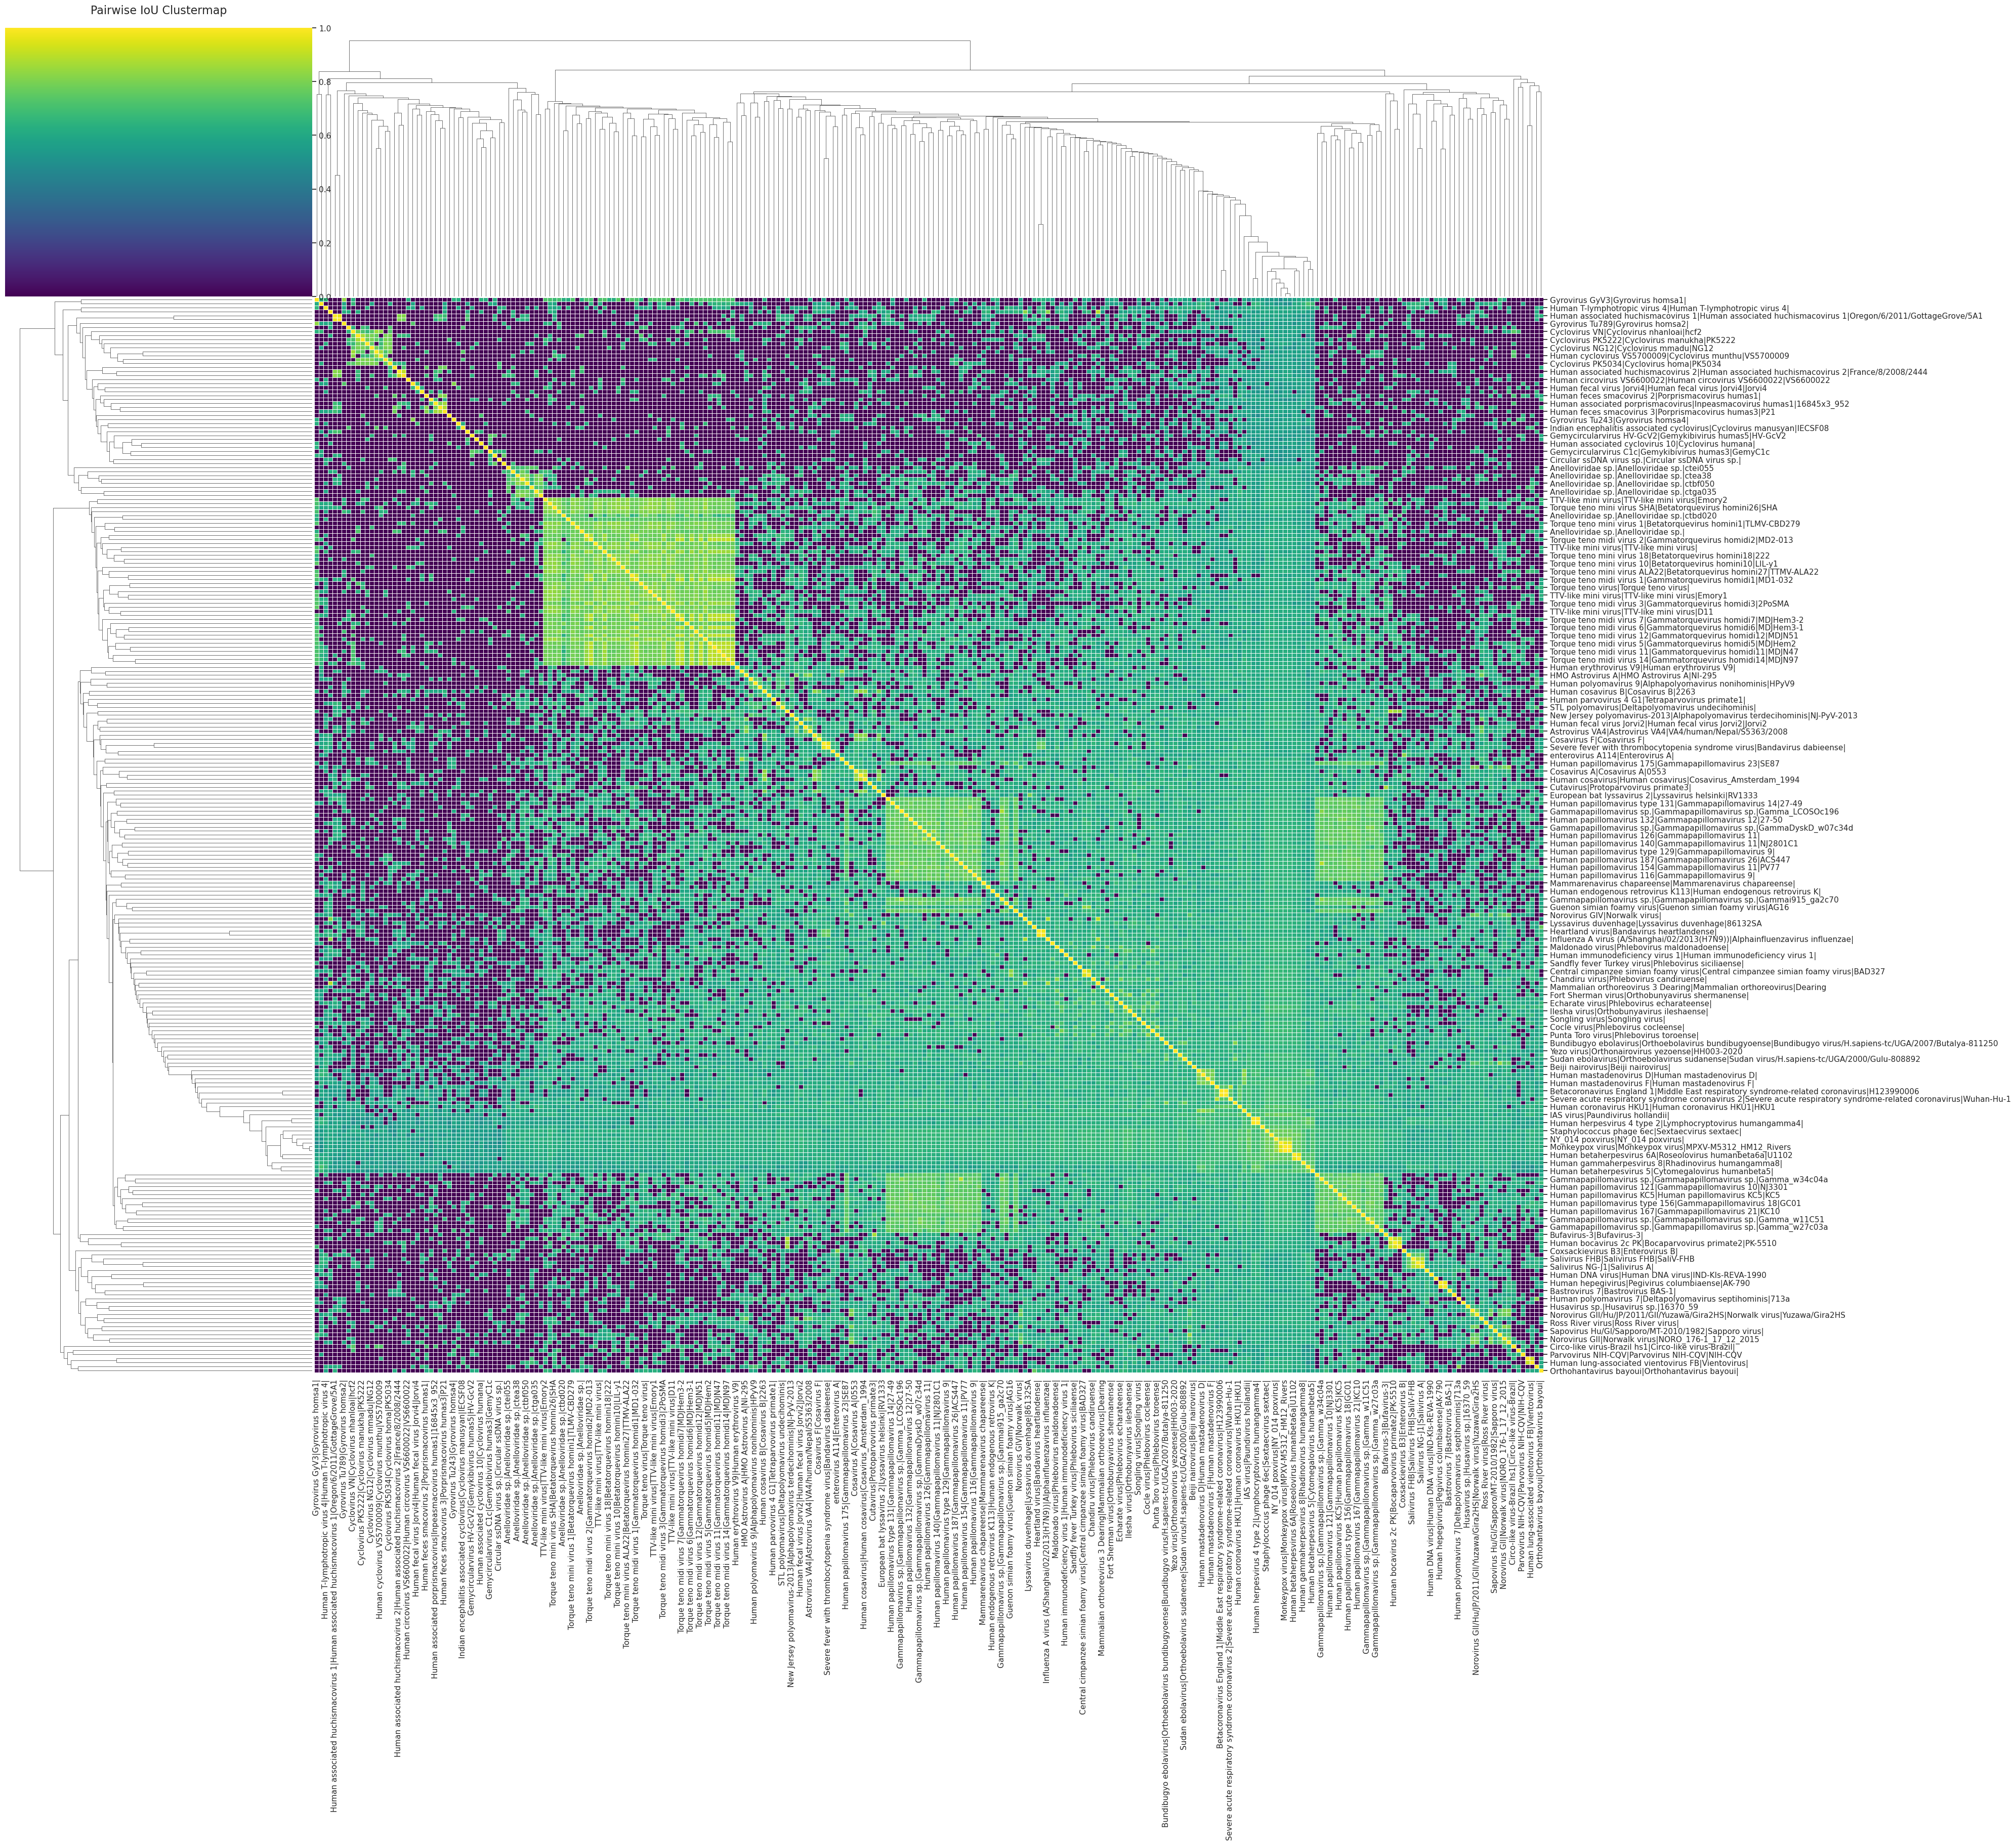

In [120]:
scaled = np.log(matrix+1e-10)
min_log = np.min(scaled)
max_log = np.max(scaled)
scaled_values = (scaled - min_log) / (max_log-min_log)
plot_clustermap(scaled_values)